[Month 01] A = 4.2278e-04 ± 1.1e-05, RA = 245.76° (Tilt Corrected)


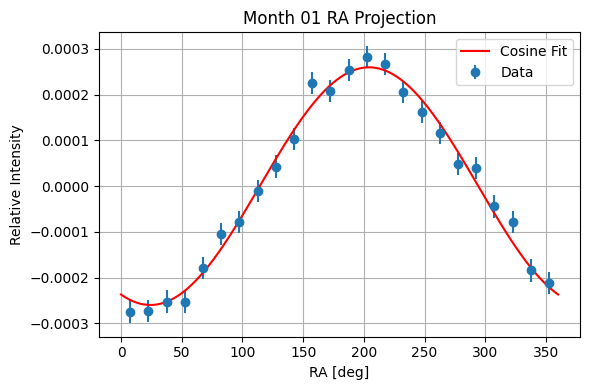

[Month 02] A = 3.8851e-04 ± 1.0e-05, RA = 215.85° (Tilt Corrected)


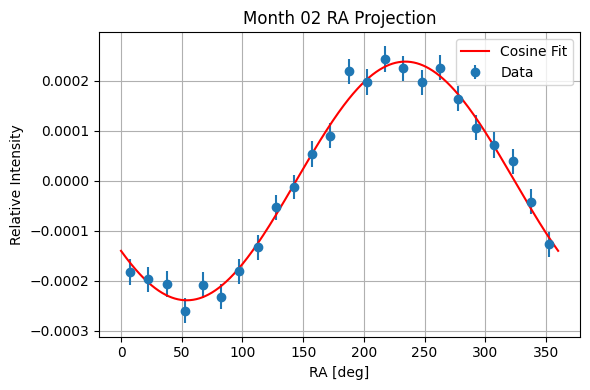

[Month 03] A = 3.9906e-04 ± 1.2e-05, RA = 183.42° (Tilt Corrected)


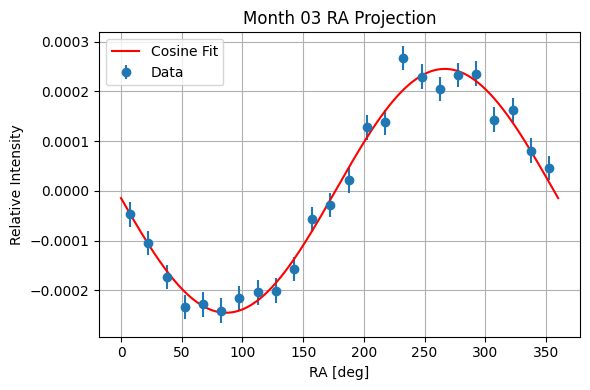

[Month 04] A = 3.8698e-04 ± 1.3e-05, RA = 152.34° (Tilt Corrected)


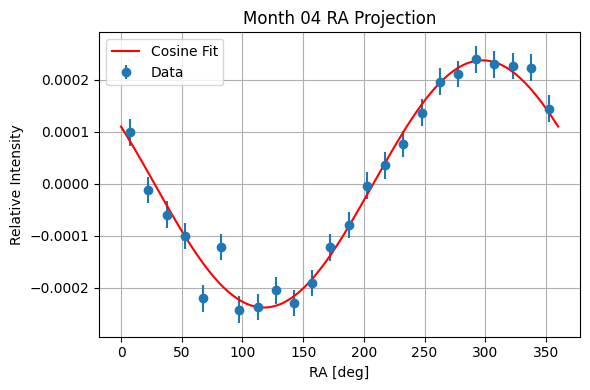

[Month 05] A = 4.2418e-04 ± 1.1e-05, RA = 123.41° (Tilt Corrected)


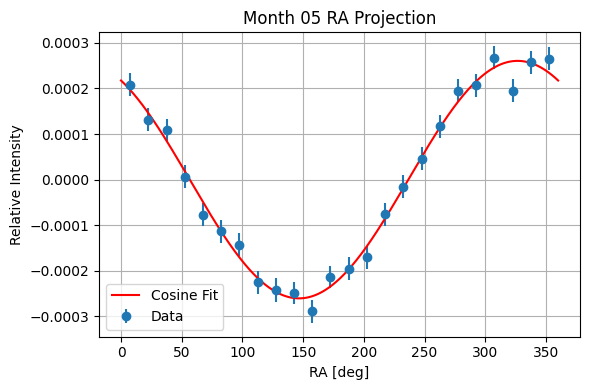

[Month 06] A = 4.7059e-04 ± 1.4e-05, RA = 93.87° (Tilt Corrected)


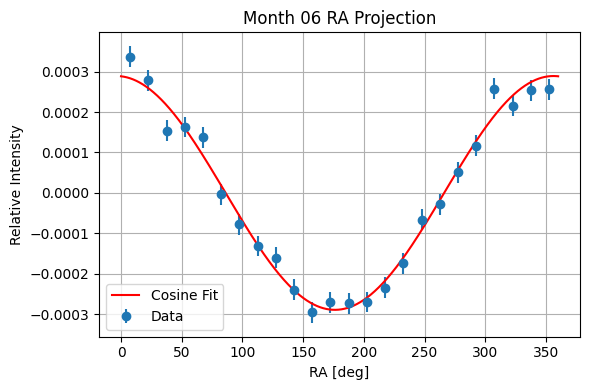

[Month 07] A = 4.4291e-04 ± 1.4e-05, RA = 69.45° (Tilt Corrected)


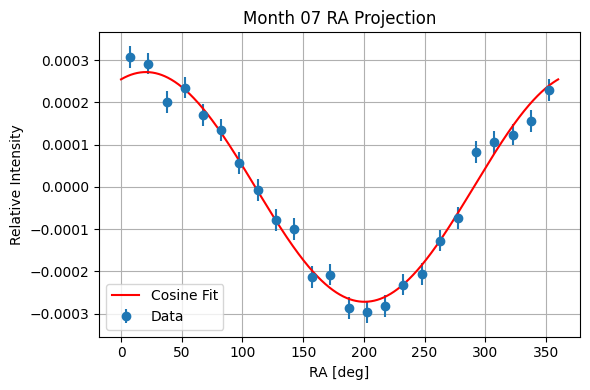

[Month 08] A = 4.2391e-04 ± 1.1e-05, RA = 37.34° (Tilt Corrected)


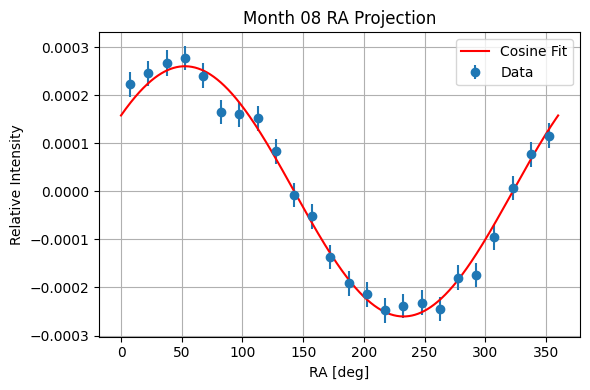

[Month 09] A = 4.3899e-04 ± 1.2e-05, RA = 10.16° (Tilt Corrected)


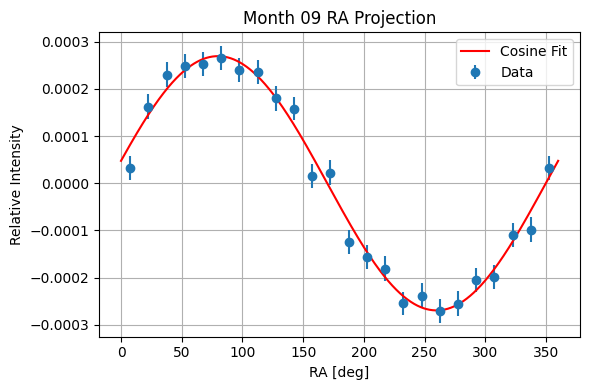

[Month 10] A = 4.2513e-04 ± 7.3e-06, RA = 335.35° (Tilt Corrected)


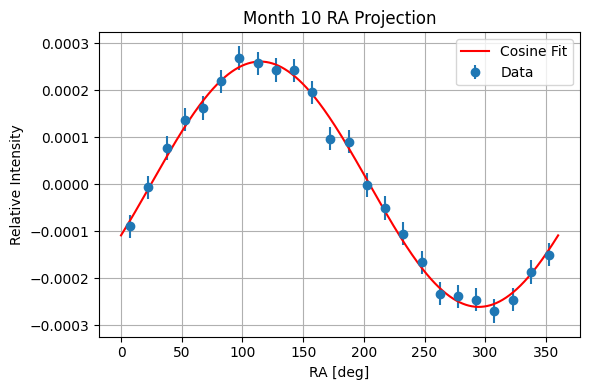

[Month 11] A = 3.9745e-04 ± 1.1e-05, RA = 302.97° (Tilt Corrected)


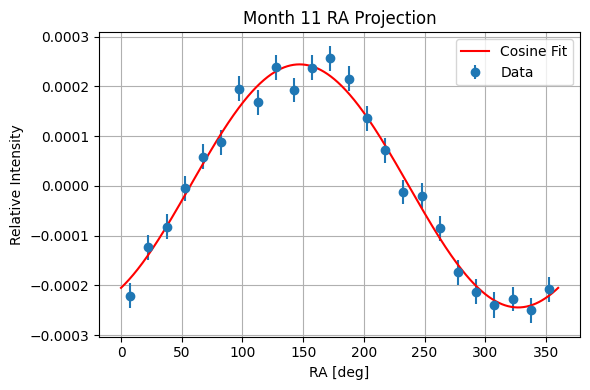

[Month 12] A = 4.3969e-04 ± 1.5e-05, RA = 272.97° (Tilt Corrected)


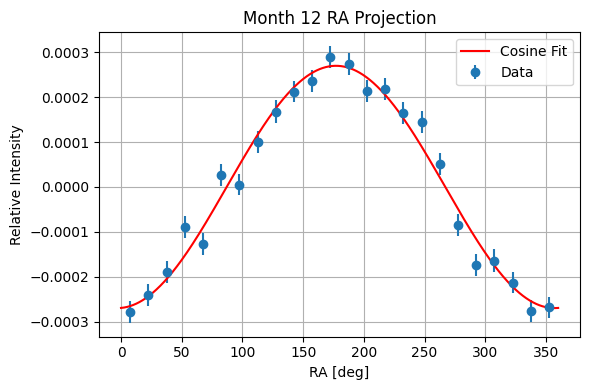

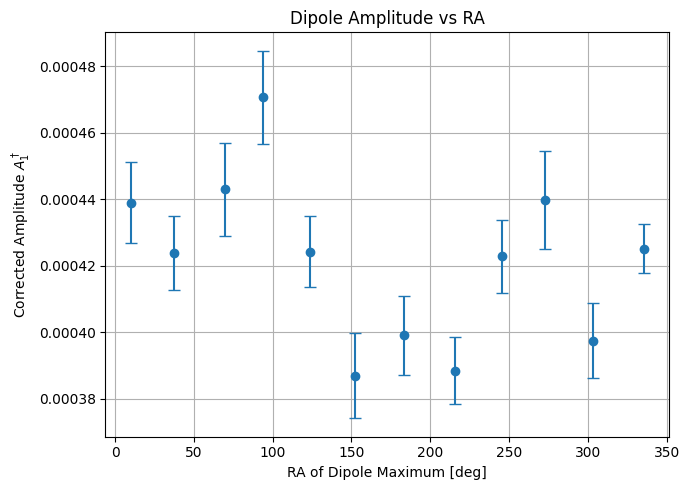

In [4]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import os
from scipy.optimize import curve_fit
from mapFunctions import getMap

# Function to get 1D RA projection
def returnRI(relint_map, relerr_map, **opts):
    degree = np.pi / 180
    ramin = opts['ramin'] * degree
    ramax = opts['ramax'] * degree
    rabins = np.linspace(ramin, ramax, opts['nbins'] + 1)

    npix = len(relint_map)
    nside = hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, range(npix))

    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, opts['nbins']))
    for i in range(opts['nbins']):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        ri[i] = np.mean(relint_map[c0])
        sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()

    dx = (ramax - ramin) / (2 * opts['nbins'])
    ra = np.linspace(ramin + dx, ramax - dx, opts['nbins']) / degree
    sigmax = dx * np.ones(opts['nbins']) / degree

    return (ra, ri, sigmax, sigmay)

# Dipole model for 1D cosine fit
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# Declination correction factor 
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Axial tilt: rotation from ecliptic to equatorial coordinates
epsilon = np.radians(23.44)  # Earth's axial tilt
dipole_ecliptic = np.array([0, 0, 1])
rot_x = np.array([
    [1, 0, 0],
    [0, np.cos(epsilon), -np.sin(epsilon)],
    [0, np.sin(epsilon),  np.cos(epsilon)]
])
dipole_equatorial = rot_x @ dipole_ecliptic
x_eq, y_eq, z_eq = dipole_equatorial
tilt_ra_offset = np.degrees(np.arctan2(y_eq, x_eq)) % 360  # Typically ~180°
tilt_ra_shift = (tilt_ra_offset - 180)  # Adjustment to apply to RA phase

# Paths
monthly_base = '/data/user/fmcnally/anisotropy/maps/merged_monthly/IC86_N10_sid_{:02d}.fits'
all_map_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'

# Load all-year map
if not os.path.isfile(all_map_file):
    raise FileNotFoundError(f"All-data map not found: {all_map_file}")
all_data, all_bg, _ = hp.read_map(all_map_file, field=(0, 1, 2))
all_relint = getMap([all_map_file], mapName='relint', smooth=0, verbose=False, mask=True)

# Output containers
amplitudes = []
errors = []
phases = []
months = []

# Loop over 12 months
for month in range(1, 13):
    month_file = monthly_base.format(month)
    if not os.path.isfile(month_file):
        print(f"Skipping month {month:02d}: file not found")
        continue

    try:
        month_data, month_bg, _ = hp.read_map(month_file, field=(0, 1, 2))
        month_relint = getMap([month_file], mapName='relint', smooth=0, verbose=False, mask=True)
    except Exception as e:
        print(f"Error loading month {month:02d}: {e}")
        continue

    if month_relint is None or all_relint is None:
        print(f"Skipping month {month:02d}: map could not be loaded.")
        continue

    # --- Compute monthly difference ---
    diff_map = month_relint - all_relint
    nside = hp.get_nside(diff_map)
    npix = hp.nside2npix(nside)
    theta, phi = hp.pix2ang(nside, np.arange(npix))

    diff_map_masked = diff_map.copy()
    north_mask = (theta < (np.pi / 2))
    data_mask = (~np.isfinite(diff_map_masked)) | (diff_map_masked == 0) | (diff_map_masked == hp.UNSEEN)
    full_mask = north_mask | data_mask
    diff_map_masked[full_mask] = hp.UNSEEN

    # Error calculation
    sigma_month = np.sqrt((month_data / month_bg)**2 * (1.0 / month_data + 1.0 / (month_bg * 20)))
    sigma_all = np.sqrt((all_data / all_bg)**2 * (1.0 / all_data + 1.0 / (all_bg * 20)))
    sigma_total = np.sqrt(sigma_month**2 + sigma_all**2)
    sigma_total[full_mask] = hp.UNSEEN

    # 1D RA projection and fit
    opts = {'ramin': 0, 'ramax': 360, 'nbins': 24}
    ra, ri, sigmax, sigmay = returnRI(diff_map_masked, sigma_total, **opts)

    try:
        popt1d, pcov1d = curve_fit(
            acos_func, ra, ri, sigma=sigmay,
            bounds=([0, 0], [0.01, 2 * np.pi])
        )
        A_1d, phi_1d = popt1d
        A_err_1d, phi_err_1d = np.sqrt(np.diag(pcov1d))

        # --- Corrected amplitude and RA ---
        A_corr = correction_factor * A_1d
        A_err_corr = correction_factor * A_err_1d
        RA_phase = (np.degrees(phi_1d)) % 360
        RA_phase_corrected = (RA_phase + tilt_ra_shift) % 360

        # --- Store results ---
        amplitudes.append(A_corr)
        errors.append(A_err_corr)
        phases.append(RA_phase_corrected)
        months.append(month)

        print(f"[Month {month:02d}] A = {A_corr:.4e} ± {A_err_corr:.1e}, "
              f"RA = {RA_phase_corrected:.2f}° (Tilt Corrected)")

        # --- Optional: plot monthly 1D fit ---
        ra_fit = np.linspace(0, 360, 1000)
        plt.figure(figsize=(6, 4))
        plt.errorbar(ra, ri, yerr=sigmay, fmt='o', label='Data')
        plt.plot(ra_fit, acos_func(ra_fit, *popt1d), 'r-', label='Cosine Fit')
        plt.xlabel('RA [deg]')
        plt.ylabel('Relative Intensity')
        plt.title(f'Month {month:02d} RA Projection')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Month {month:02d}] Fit failed: {e}")
        continue

# --- Final summary plot: amplitude vs tilt-corrected RA ---
plt.figure(figsize=(7, 5))
plt.errorbar(phases, amplitudes, yerr=errors, fmt='o', capsize=4)
plt.xlabel('RA of Dipole Maximum [deg]')
plt.ylabel('Corrected Amplitude $A_1^\\dagger$')
plt.title('Dipole Amplitude vs RA')
plt.grid(True)
plt.tight_layout()
plt.show()
measured_amplitudes = np.array(amplitudes)
measured_errors = np.array(errors)
measured_phases = np.array(phases)
measured_months = np.array(months)

[Month 01] Averaged A_CG = 4.1444e-04 ± 3.2e-06


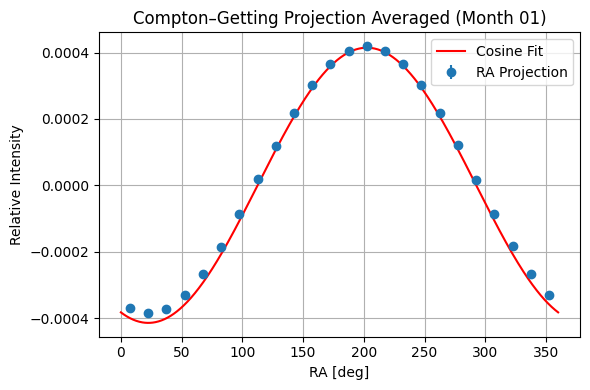

[Month 02] Averaged A_CG = 4.1262e-04 ± 5.2e-06


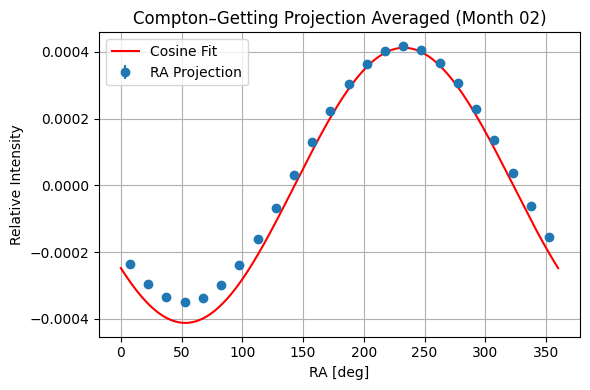

[Month 03] Averaged A_CG = 4.0250e-04 ± 7.6e-06


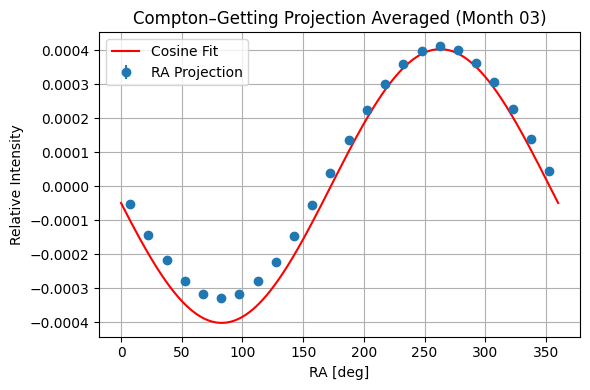

[Month 04] Averaged A_CG = 4.0279e-04 ± 6.4e-06


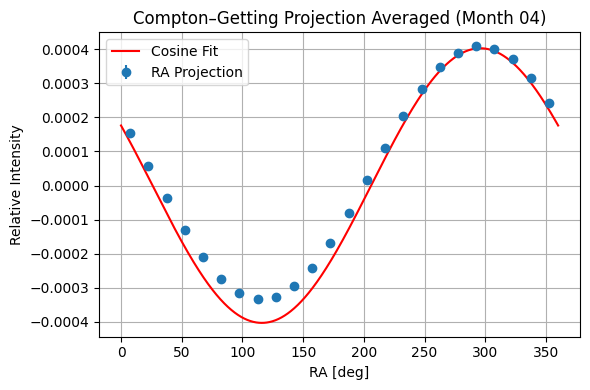

[Month 05] Averaged A_CG = 4.0623e-04 ± 3.3e-06


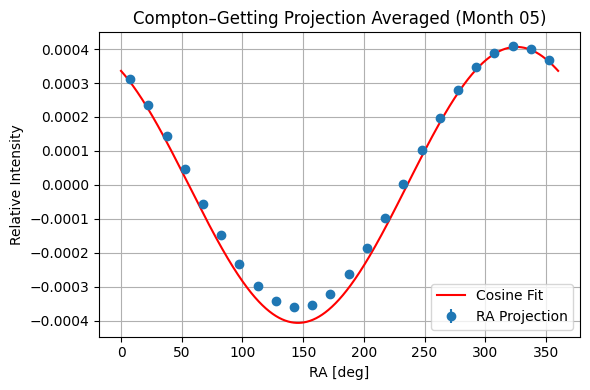

[Month 06] Averaged A_CG = 3.9497e-04 ± 1.2e-06


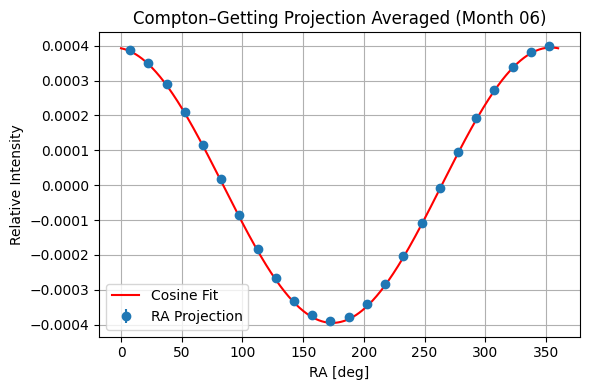

[Month 07] Averaged A_CG = 4.0035e-04 ± 3.0e-06


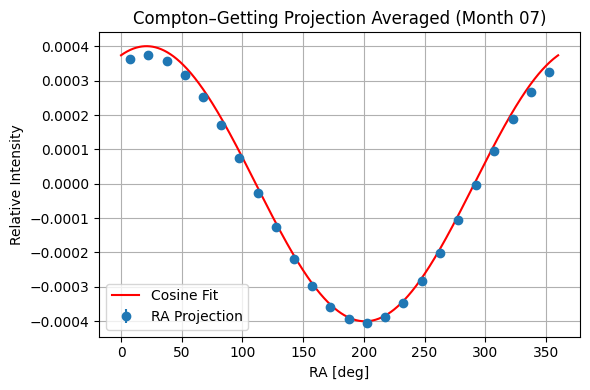

[Month 08] Averaged A_CG = 4.0308e-04 ± 4.7e-06


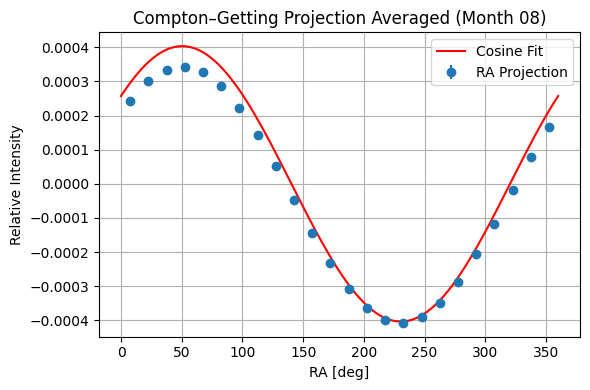

[Month 09] Averaged A_CG = 3.9802e-04 ± 7.5e-06


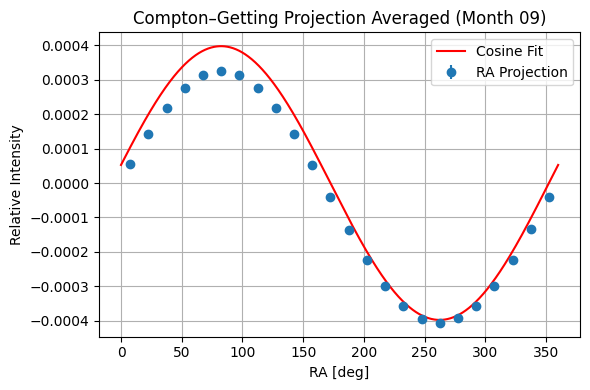

[Month 10] Averaged A_CG = 4.0477e-04 ± 6.6e-06


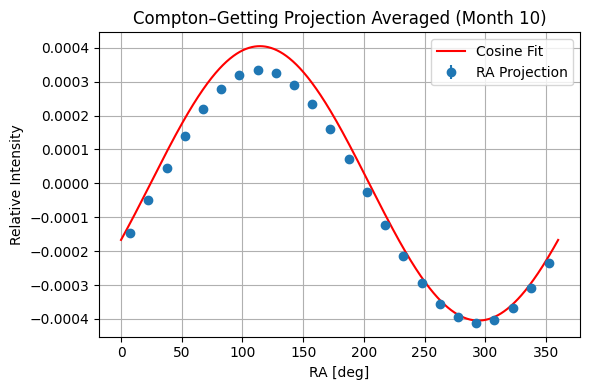

[Month 11] Averaged A_CG = 4.1518e-04 ± 3.3e-06


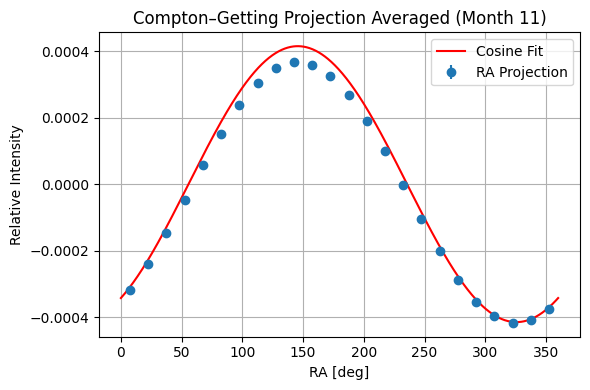

[Month 12] Averaged A_CG = 4.0773e-04 ± 1.3e-06


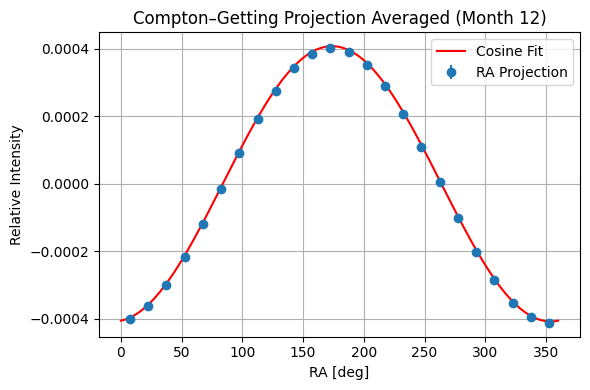

In [5]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const

# --- Settings ---
gamma = 2.6
cg_factor = gamma + 2
tilt_deg = 23.44
cos_tilt = np.cos(np.radians(tilt_deg))
months = np.arange(1, 13)
years = np.arange(2012, 2023)  # Averaging from 2012 to 2022

# HEALPix map setup
nside = 64
npix = hp.nside2npix(nside)
pixs = np.arange(npix)
theta, phi = hp.pix2ang(nside, pixs)

# IceCube southern sky FoV (declination -30° to -90° ⇒ θ = 90°–120°)
fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))

# --- Cosine function for dipole fitting ---
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# --- ReturnRI: RA projection of dipole map ---
def returnRI(relint_map, relerr_map, **opts):
    degree = np.pi / 180
    ramin = opts['ramin'] * degree
    ramax = opts['ramax'] * degree
    rabins = np.linspace(ramin, ramax, opts['nbins'] + 1)

    theta, phi = hp.pix2ang(hp.npix2nside(len(relint_map)), np.arange(len(relint_map)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, opts['nbins']))
    for i in range(opts['nbins']):
        c0 = cut * (phiBins == i)
        if np.sum(c0) > 0:
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.std(relint_map[c0]) / np.sqrt(np.sum(c0))
        else:
            ri[i] = np.nan
            sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * opts['nbins'])
    ra = np.linspace(ramin + dx, ramax - dx, opts['nbins']) / degree
    sigmax = dx * np.ones(opts['nbins']) / degree

    return ra, ri, sigmax, sigmay

# --- Storage ---
cg_amplitudes = []
cg_errors = []
cg_phases = []

# --- Loop over months with multi-year averaging ---
opts = {'ramin': 0, 'ramax': 360, 'nbins': 24}

for month in months:
    # --- Average Earth's velocity vectors across all years for the month ---
    v_list = []
    for year in years:
        t = Time(f"{year}-{month:02d}-15T00:00:00", scale='utc')
        _, vel = get_body_barycentric_posvel('earth', t)
        v = np.array([vel.x.to('m/s').value, vel.y.to('m/s').value, vel.z.to('m/s').value])
        v_list.append(v)

    v_avg = np.mean(v_list, axis=0)
    vhat = v_avg / np.linalg.norm(v_avg)
    A_CG = cg_factor * (np.linalg.norm(v_avg) / const.c.value)

    # --- Compute dipole map ---
    vecs = hp.pix2vec(nside, pixs)
    dots = np.dot(vhat, vecs)
    dipole = A_CG * dots * cos_tilt

    # Mask for IceCube southern sky
    dipole_masked = np.full(npix, hp.UNSEEN)
    dipole_masked[fov_mask] = dipole[fov_mask]

    # Dummy error map
    dummy_err = np.full(npix, 1e-5)
    dummy_err[~fov_mask] = hp.UNSEEN

    # --- Project to RA ---
    ra, ri, _, sigmay = returnRI(dipole_masked, dummy_err, **opts)

    # --- Fit cosine ---
    try:
        popt, pcov = curve_fit(acos_func, ra, ri, sigma=sigmay,
                               bounds=([0, 0], [0.01, 2*np.pi]))
        A, phi = popt
        A_err, phi_err = np.sqrt(np.diag(pcov))

        RA_phase = (np.degrees(phi)) % 360
        cg_amplitudes.append(A)
        cg_errors.append(A_err)
        cg_phases.append(RA_phase)

        print(f"[Month {month:02d}] Averaged A_CG = {A:.4e} ± {A_err:.1e}")

        # Plot projection and fit
        ra_fit = np.linspace(0, 360, 1000)
        plt.figure(figsize=(6, 4))
        plt.errorbar(ra, ri, yerr=sigmay, fmt='o', label='RA Projection')
        plt.plot(ra_fit, acos_func(ra_fit, *popt), 'r-', label='Cosine Fit')
        plt.xlabel('RA [deg]')
        plt.ylabel('Relative Intensity')
        plt.title(f'Compton–Getting Projection Averaged (Month {month:02d})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Month {month:02d}] Fit failed: {e}")
        cg_amplitudes.append(np.nan)
        cg_errors.append(np.nan)
        cg_phases.append(np.nan)


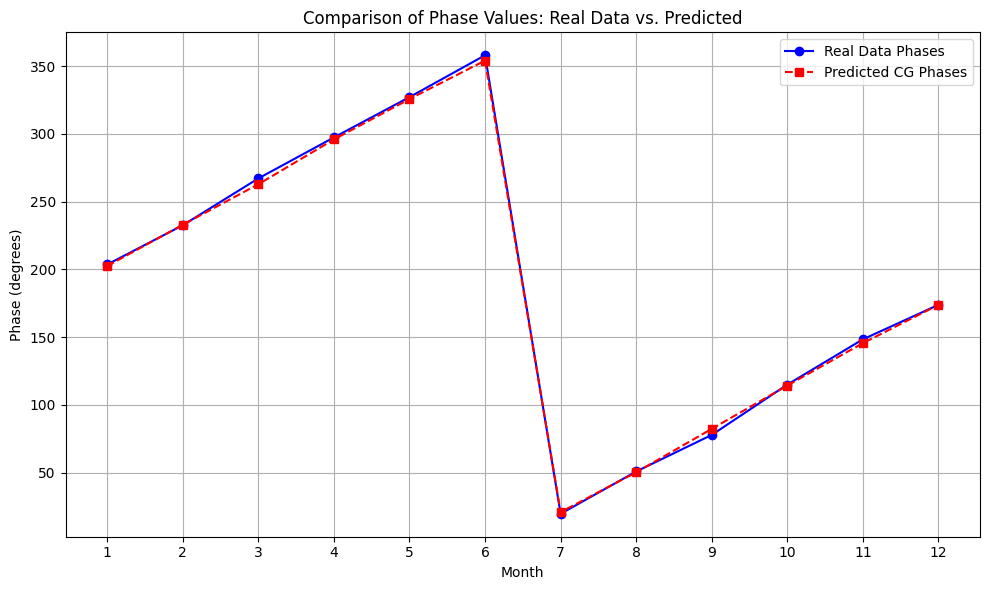

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u, constants as const
from mapFunctions import getMap

# --- Paths ---
monthly_base = '/data/user/fmcnally/anisotropy/maps/merged_monthly/IC86_N10_sid_{:02d}.fits'
all_map_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'

# --- Dipole fit model ---
def cos2d(ang, A, phi):
    psi = hp.rotator.angdist(ang, [0.5 * np.pi, phi])
    return A * np.cos(psi)

# --- Load 12-year reference map ---
if not os.path.isfile(all_map_file):
    raise FileNotFoundError(f"All-data map not found: {all_map_file}")
all_data, all_bg, _ = hp.read_map(all_map_file, field=(0, 1, 2))
all_relint = getMap([all_map_file], mapName='relint', smooth=20, verbose=False, mask=True)

# --- Prepare arrays to store real data phases ---
real_data_phases_deg = []

# --- Loop over months to fit real data ---
for month in range(1, 13):
    month_file = monthly_base.format(month)
    if not os.path.isfile(month_file):
        print(f"Skipping month {month:02d}: file not found")
        real_data_phases_deg.append(np.nan)
        continue

    try:
        month_data, month_bg, _ = hp.read_map(month_file, field=(0, 1, 2))
        month_relint = getMap([month_file], mapName='relint', smooth=20, verbose=False, mask=True)
    except Exception as e:
        print(f"Error loading month {month:02d}: {e}")
        real_data_phases_deg.append(np.nan)
        continue

    if month_relint is None or all_relint is None:
        print(f"Skipping month {month:02d}: map could not be loaded.")
        real_data_phases_deg.append(np.nan)
        continue

    diff_map = month_relint - all_relint

    nside = hp.get_nside(diff_map)
    npix = hp.nside2npix(nside)
    theta, phi = hp.pix2ang(nside, np.arange(npix))

    diff_map_masked = diff_map.copy()

    # Mask northern hemisphere and invalid pixels
    north_mask = (theta < (np.pi / 2))
    data_mask = (~np.isfinite(diff_map_masked)) | (diff_map_masked == 0) | (diff_map_masked == hp.UNSEEN)
    full_mask = north_mask | data_mask
    diff_map_masked[full_mask] = hp.UNSEEN

    # IceCube FoV: Decl. -30° to -90° (θ = 90°–120°)
    fov_pixels = np.where((theta >= np.radians(90)) & (theta <= np.radians(120)))[0]
    fov_angles = hp.pix2ang(nside, fov_pixels)
    fov_values = diff_map[fov_pixels]

    # Error calculation
    sigma_month = np.sqrt((month_data / month_bg) ** 2 * (1.0 / month_data + 1.0 / (month_bg * 20)))
    sigma_all = np.sqrt((all_data / all_bg) ** 2 * (1.0 / all_data + 1.0 / (all_bg * 20)))
    sigma_total = np.sqrt(sigma_month ** 2 + sigma_all ** 2)
    sigma_fov = sigma_total[fov_pixels]

    # Fit dipole phase
    try:
        popt, pcov = curve_fit(
            cos2d,
            fov_angles,
            fov_values,
            sigma=sigma_fov,
            bounds=([0, 0], [0.01, 2 * np.pi])
        )
        A_fit, phi_fit = popt
        A_err, phi_err = np.sqrt(np.diag(pcov))
        phase_deg = np.degrees(phi_fit)
        real_data_phases_deg.append(phase_deg)
    except Exception as e:
        print(f"[Month {month:02d}] Fit failed: {e}")
        real_data_phases_deg.append(np.nan)

# --- Prediction: Compute CG phases ---
years = np.arange(2012, 2023)
months = np.arange(1, 13)
t_list = [f"{y:04d}-{m:02d}-15T00:00:00" for y in years for m in months]
t_array = Time(t_list, scale='utc')

_, vel_array = get_body_barycentric_posvel('earth', t_array)

vx = vel_array.x.to_value(u.km / u.s).reshape(len(years), 12)
vy = vel_array.y.to_value(u.km / u.s).reshape(len(years), 12)
vz = vel_array.z.to_value(u.km / u.s).reshape(len(years), 12)

cg_phases = []
for month in range(12):
    v = np.array([vx[:, month].mean(), vy[:, month].mean(), vz[:, month].mean()])
    v_hat = v / np.linalg.norm(v)
    x, y, z = v_hat
    ra = np.arctan2(y, x)
    if ra < 0:
        ra += 2 * np.pi
    cg_phases.append(np.degrees(ra))

# --- Plot comparison ---
months = np.arange(1, 13)
plt.figure(figsize=(10, 6))
plt.plot(months, real_data_phases_deg, marker='o', linestyle='-', color='blue', label='Real Data Phases')
plt.plot(months, cg_phases, marker='s', linestyle='--', color='red', label='Predicted CG Phases')

plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Phase (degrees)')
plt.title('Comparison of Phase Values: Real Data vs. Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Selected Year: 2016
[Month 01] CG: A = 4.644e-04, φ = 203.00°
  Data Fit: A = 0.000153 ± 9e-06, φ = 201.67° ± 3.22°
[Month 02] CG: A = 4.625e-04, φ = 232.48°
  Data Fit: A = 0.000137 ± 9e-06, φ = 238.24° ± 3.72°
[Month 03] CG: A = 4.592e-04, φ = 264.19°
  Data Fit: A = 0.0001478 ± 9e-06, φ = 269.00° ± 3.36°
[Month 04] CG: A = 4.553e-04, φ = 296.69°
  Data Fit: A = 0.0001312 ± 9e-06, φ = 299.84° ± 3.92°
[Month 05] CG: A = 4.519e-04, φ = 326.91°
  Data Fit: A = 0.0001745 ± 9e-06, φ = 327.30° ± 2.91°
[Month 06] CG: A = 4.499e-04, φ = 354.76°
  Data Fit: A = 0.0001668 ± 9e-06, φ = 355.09° ± 3.06°
[Month 07] CG: A = 4.497e-04, φ = 22.11°
  Data Fit: A = 0.0001677 ± 9e-06, φ = 20.04° ± 3.07°
[Month 08] CG: A = 4.515e-04, φ = 51.63°
  Data Fit: A = 0.0001209 ± 9e-06, φ = 51.27° ± 4.32°
[Month 09] CG: A = 4.547e-04, φ = 83.23°
  Data Fit: A = 0.0001714 ± 9e-06, φ = 78.28° ± 3.03°
[Month 10] CG: A = 4.586e-04, φ = 115.67°
  Data Fit: A = 0.0001565 ± 8e-06, φ = 116.78° ± 3.06°
[Month 11] CG: A =

[Month 01] A = 4.2278e-04 ± 1.1e-05
[Month 02] A = 3.8851e-04 ± 1.0e-05
[Month 03] A = 3.9906e-04 ± 1.2e-05
[Month 04] A = 3.8698e-04 ± 1.3e-05
[Month 05] A = 4.2418e-04 ± 1.1e-05
[Month 06] A = 4.7059e-04 ± 1.4e-05
[Month 07] A = 4.4291e-04 ± 1.4e-05
[Month 08] A = 4.2391e-04 ± 1.1e-05
[Month 09] A = 4.3899e-04 ± 1.2e-05
[Month 10] A = 4.2513e-04 ± 7.3e-06
[Month 11] A = 3.9745e-04 ± 1.1e-05
[Month 12] A = 4.3969e-04 ± 1.5e-05

Computing CG model for year: 2013


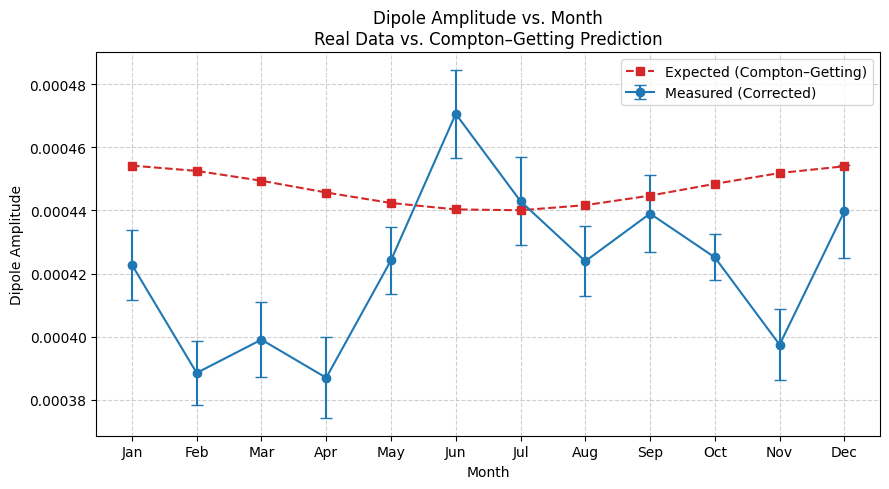

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const, units as u
from mapFunctions import getMap
import random

# === Constants and Paths ===
monthly_base = '/data/user/fmcnally/anisotropy/maps/merged_monthly/IC86_N10_sid_{:02d}.fits'
all_map_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
months = np.arange(1, 13)

# === Declination correction (IceCube southern sky) ===
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# === 1D Dipole model ===
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# === RA projection ===
def returnRI(relint_map, relerr_map, **opts):
    degree = np.pi / 180
    ramin = opts['ramin'] * degree
    ramax = opts['ramax'] * degree
    rabins = np.linspace(ramin, ramax, opts['nbins'] + 1)
    npix = len(relint_map)
    nside = hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, opts['nbins']))
    for i in range(opts['nbins']):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        ri[i] = np.mean(relint_map[c0])
        sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()

    dx = (ramax - ramin) / (2 * opts['nbins'])
    ra = np.linspace(ramin + dx, ramax - dx, opts['nbins']) / degree
    sigmax = dx * np.ones(opts['nbins']) / degree
    return (ra, ri, sigmax, sigmay)

# === Load full 12-year map ===
if not os.path.isfile(all_map_file):
    raise FileNotFoundError(f"All-data map not found: {all_map_file}")
all_data, all_bg, _ = hp.read_map(all_map_file, field=(0, 1, 2))
all_relint = getMap([all_map_file], mapName='relint', smooth=0, verbose=False, mask=True)

# === Output containers for real data ===
measured_amplitudes = []
measured_errors = []
measured_months = []

# === Loop over 12 months to compute measured amplitudes ===
for month in months:
    month_file = monthly_base.format(month)
    if not os.path.isfile(month_file):
        print(f"Skipping month {month:02d}: file not found")
        continue

    month_data, month_bg, _ = hp.read_map(month_file, field=(0, 1, 2))
    month_relint = getMap([month_file], mapName='relint', smooth=0, verbose=False, mask=True)
    if month_relint is None or all_relint is None:
        continue

    diff_map = month_relint - all_relint
    nside = hp.get_nside(diff_map)
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    diff_map_masked = diff_map.copy()
    mask = (theta < (np.pi / 2)) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
    diff_map_masked[mask] = hp.UNSEEN

    sigma_month = np.sqrt((month_data / month_bg)**2 * (1.0 / month_data + 1.0 / (month_bg * 20)))
    sigma_all = np.sqrt((all_data / all_bg)**2 * (1.0 / all_data + 1.0 / (all_bg * 20)))
    sigma_total = np.sqrt(sigma_month**2 + sigma_all**2)
    sigma_total[mask] = hp.UNSEEN

    opts = {'ramin': 0, 'ramax': 360, 'nbins': 24}
    ra, ri, _, sigmay = returnRI(diff_map_masked, sigma_total, **opts)

    try:
        popt1d, pcov1d = curve_fit(
            acos_func, ra, ri, sigma=sigmay,
            bounds=([0, 0], [0.01, 2 * np.pi])
        )
        A_1d, phi_1d = popt1d
        A_err_1d, phi_err_1d = np.sqrt(np.diag(pcov1d))

        A_corr = correction_factor * A_1d
        A_err_corr = correction_factor * A_err_1d

        measured_amplitudes.append(A_corr)
        measured_errors.append(A_err_corr)
        measured_months.append(month)

        print(f"[Month {month:02d}] A = {A_corr:.4e} ± {A_err_corr:.1e}")

    except Exception as e:
        print(f"Fit failed for month {month:02d}: {e}")

# === Compute CG amplitudes ===
year = random.randint(2000, 2024)
print(f"\nComputing CG model for year: {year}")

t_daily = []
for m in months:
    t_start = Time(f"{year}-{m:02d}-01T00:00:00", scale='utc')
    t_end = Time(f"{year}-{m%12 + 1:02d}-01T00:00:00", scale='utc') if m < 12 else Time(f"{year+1}-01-01T00:00:00", scale='utc')
    n_days = int((t_end - t_start).value)
    t_daily += [f"{year}-{m:02d}-{d+1:02d}T00:00:00" for d in range(n_days)]
t_array = Time(t_daily, scale='utc')

_, vel_array = get_body_barycentric_posvel('earth', t_array)
vx_daily = vel_array.x.to(u.km/u.s).value
vy_daily = vel_array.y.to(u.km/u.s).value
vz_daily = vel_array.z.to(u.km/u.s).value
speed_daily = vel_array.norm().to(u.km/u.s).value

month_day_counts = [len([t for t in t_daily if int(t[5:7]) == m]) for m in months]
idx_split = np.cumsum(month_day_counts)
speed_split = np.split(speed_daily, idx_split[:-1])

gamma = 2.5
cg_factor = gamma + 2
cg_amplitudes = []
for i in range(12):
    v_mag = np.mean(speed_split[i])
    amp = cg_factor * (v_mag * 1e3 / const.c.value)
    cg_amplitudes.append(amp)

# === Plot: Real vs. CG Amplitudes ===
plt.figure(figsize=(9, 5))

# Real data
plt.errorbar(
    measured_months, measured_amplitudes, yerr=measured_errors,
    fmt='o-', capsize=4, label='Measured (Corrected)', color='tab:blue'
)

# CG model
plt.plot(months, cg_amplitudes, 's--', label='Expected (Compton–Getting)', color='tab:red')

# Labels and format
plt.xticks(ticks=np.arange(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.xlabel('Month')
plt.ylabel('Dipole Amplitude')
plt.title('Dipole Amplitude vs. Month\nReal Data vs. Compton–Getting Prediction')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_amplitude_comparison.png', dpi=300)
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u
import random

# === Assumed Input ===
# - measured_phases: in degrees, from 1D fits with axial tilt correction (length = 12)
# - measured_months: list of months (1–12)
# (from previous amplitude fitting script)

measured_phases = np.array(measured_phases)  # already tilt-corrected RA (0–360)
measured_months = np.array(measured_months)

# === Compute CG Phases ===
months = np.arange(1, 13)
year = random.randint(2000, 2024)
print(f"Computing CG phases for year: {year}")

cg_phases = []
for month in months:
    t = Time(f"{year}-{month:02d}-15T00:00:00", scale='utc')  # middle of month
    _, vel = get_body_barycentric_posvel('earth', t)
    v = np.array([vel.x.to_value(u.km/u.s), vel.y.to_value(u.km/u.s), vel.z.to_value(u.km/u.s)])
    v_hat = v / np.linalg.norm(v)

    x, y, z = v_hat
    ra = np.arctan2(y, x)
    if ra < 0:
        ra += 2 * np.pi
    cg_phases.append(np.degrees(ra))

cg_phases = np.array(cg_phases)

# === Plotting ===
plt.figure(figsize=(9, 5))

plt.plot(
    months, cg_phases, 's--', color='tab:red', label='Expected CG Phase (RA)',
)
plt.plot(
    measured_months, measured_phases, 'o-', color='tab:blue', label='Measured Phase (Tilt-Corrected)',
)

# Format and Labels
plt.xticks(ticks=np.arange(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.xlabel('Month')
plt.ylabel('RA of Dipole Maximum [deg]')
plt.title('Dipole Phase vs. Month\nMeasured vs. Compton–Getting Prediction')
plt.ylim(0, 360)
plt.yticks(np.arange(0, 361, 60))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_phase_comparison.png', dpi=300)
plt.show()


NameError: name 'measured_phases' is not defined